## INTRODUCTION
- A machine learning project to automatically detect Capuchin bird calls in forest recordings using Deep Learning and audio signal processing.
- Dataset: Capuchin bird audio clips + forest background sounds.
- Method: CNN with Spectrogram analysis.

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall
from itertools import groupby
import librosa
import warnings
warnings.filterwarnings('ignore')

2025-09-11 06:41:38.899569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757572899.273389      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757572899.384018      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## CONFIGURATION

In [2]:
POSITIVE_PATH = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
NEGATIVE_PATH = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'
FOREST_PATH = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings'

SAMPLE_RATE = 16000
AUDIO_LENGTH = 48000
BATCH_SIZE = 2
EPOCHS = 5

## AUDIO PROCESSING

In [3]:
def load_audio_file(filename):
    """Load single audio file using librosa"""
    try:
        audio, _ = librosa.load(filename, sr=SAMPLE_RATE, mono=True)
        return audio
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return np.zeros(AUDIO_LENGTH)

In [4]:
def audio_to_spectrogram(audio):
    """Convert audio to spectrogram using librosa"""
    try:
        
        if len(audio) < AUDIO_LENGTH:
            audio = np.pad(audio, (0, AUDIO_LENGTH - len(audio)))
        else:
            audio = audio[:AUDIO_LENGTH]
        
        
        spec = librosa.stft(audio, hop_length=32, n_fft=320)
        spec = np.abs(spec)
        spec = np.expand_dims(spec, axis=2)
        return spec
    except Exception as e:
        print(f"Error creating spectrogram: {e}")
        return np.zeros((161, 1501, 1))

## DATA PREPARATION

In [5]:
def create_dataset():
    """Create training and testing datasets using numpy preprocessing"""
    print("Creating dataset with numpy preprocessing...")
    
    
    if not os.path.exists(POSITIVE_PATH):
        print(f"POSITIVE_PATH does not exist: {POSITIVE_PATH}")
        return None, None, None, None
    if not os.path.exists(NEGATIVE_PATH):
        print(f"NEGATIVE_PATH does not exist: {NEGATIVE_PATH}")
        return None, None, None, None
    
    
    pos_files = [os.path.join(POSITIVE_PATH, f) for f in os.listdir(POSITIVE_PATH) if f.endswith('.wav')]
    neg_files = [os.path.join(NEGATIVE_PATH, f) for f in os.listdir(NEGATIVE_PATH) if f.endswith('.wav')]
    
    print(f"Files found: {len(pos_files)} positive, {len(neg_files)} negative")
    
   
    max_files_per_class = 100
    pos_files = pos_files[:max_files_per_class]
    neg_files = neg_files[:max_files_per_class]
    
    X = []
    y = []
    
    print("Processing positive files...")
    for i, file_path in enumerate(pos_files):
        if i % 10 == 0:
            print(f"Processing positive file {i+1}/{len(pos_files)}")
        
        audio = load_audio_file(file_path)
        if audio is not None:
            spec = audio_to_spectrogram(audio)
            X.append(spec)
            y.append(1)
    
    print("Processing negative files...")
    for i, file_path in enumerate(neg_files):
        if i % 10 == 0:
            print(f"Processing negative file {i+1}/{len(neg_files)}")
        
        audio = load_audio_file(file_path)
        if audio is not None:
            spec = audio_to_spectrogram(audio)
            X.append(spec)
            y.append(0)
    
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    print(f"Final data shape: X={X.shape}, y={y.shape}")
    
    
    total_samples = len(X)
    split_idx = int(0.8 * total_samples)
    
    
    indices = np.random.permutation(total_samples)
    X = X[indices]
    y = y[indices]
    
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print(f"Train set: X={X_train.shape}, y={y_train.shape}")
    print(f"Test set: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test

## MODEL AND TRAINING

In [6]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        Conv2D(32, (3,3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='Adam',
                  loss='BinaryCrossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

In [7]:
def train_model(model, X_train, X_test, y_train, y_test):
    """Train model using numpy arrays (with preprocessing fixes)"""
    
    
    if len(X_train.shape) == 3:
        X_train = np.expand_dims(X_train, -1)
        X_test = np.expand_dims(X_test, -1)
    
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        verbose=1
    )
    
   
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    return history

## FOREST ANALYSIS

In [8]:
def analyze_recording(filename, model):
    """Analyze forest recording for bird calls"""
    try:
        print(f"Analyzing {filename}...")
        
        
        audio, _ = librosa.load(filename, sr=SAMPLE_RATE, mono=True)
        
        
        num_windows = len(audio) // AUDIO_LENGTH
        predictions = []
        
        for i in range(num_windows):
            start = i * AUDIO_LENGTH
            end = start + AUDIO_LENGTH
            window = audio[start:end]
            
           
            spec = audio_to_spectrogram(window)
            spec = np.expand_dims(spec, axis=0)  # إضافة batch dimension
            
            
            pred = model.predict(spec, verbose=0)[0][0]
            predictions.append(1 if pred > 0.7 else 0)
        
        
        grouped = [key for key, group in groupby(predictions)]
        call_count = sum(grouped)
        
        return call_count
        
    except Exception as e:
        print(f"Error analyzing {filename}: {e}")
        return 0

In [9]:
def save_results(results):
    """Save results to CSV file"""
    try:
        with open('results.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Recording', 'Capuchin_Calls'])
            for name, count in results.items():
                writer.writerow([name, count])
        print("Results saved to 'results.csv'")
    except Exception as e:
        print(f"Error saving results: {e}")

## MAIN EXECUTION

In [10]:
def main():
    """Main execution function"""
    print("Starting Bird Audio Classification...")
    
    
    X_train, X_test, y_train, y_test = create_dataset()
    
    if X_train is None:
        print("Failed to create dataset. Check file paths.")
        return None
    
    
    input_shape = X_train.shape[1:]  # (height, width, channels)
    model = build_model(input_shape)
    model.summary()
    
    
    history = train_model(model, X_train, X_test, y_train, y_test)
    
    
    results = model.evaluate(X_test, y_test, verbose=0)
    metrics = dict(zip(model.metrics_names, results))
    
    print("\nTest Results:")
    for name, value in metrics.items():
        print(f"{name}: {value:.3f}")
    
   
    if FOREST_PATH and os.path.exists(FOREST_PATH):
        print(f"\nAnalyzing forest recordings...")
        results = {}
        
        
        audio_files = [f for f in os.listdir(FOREST_PATH) 
                       if f.endswith(('.mp3', '.wav'))]
        
       
        for filename in audio_files[:3]:
            filepath = os.path.join(FOREST_PATH, filename)
            calls = analyze_recording(filepath, model)
            results[filename] = calls
            print(f"{filename}: {calls} calls detected")
        
        
        save_results(results)
    else:
        print(f"Forest recordings path not found: {FOREST_PATH}")
    
    print("\nAnalysis completed successfully!")
    return model, history, metrics

## RUN THE PROJECT

Starting Bird Audio Classification...
Creating dataset with numpy preprocessing...
Files found: 217 positive, 593 negative
Processing positive files...
Processing positive file 1/100
Processing positive file 11/100
Processing positive file 21/100
Processing positive file 31/100
Processing positive file 41/100
Processing positive file 51/100
Processing positive file 61/100
Processing positive file 71/100
Processing positive file 81/100
Processing positive file 91/100
Processing negative files...
Processing negative file 1/100
Processing negative file 11/100
Processing negative file 21/100
Processing negative file 31/100
Processing negative file 41/100
Processing negative file 51/100
Processing negative file 61/100
Processing negative file 71/100
Processing negative file 81/100
Processing negative file 91/100
Final data shape: X=(200, 161, 1501, 1), y=(200,)
Train set: X=(160, 161, 1501, 1), y=(160,)
Test set: X=(40, 161, 1501, 1), y=(40,)


I0000 00:00:1757572941.690117      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757572941.690816      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 159, 1499, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 1497, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,153 (35.75 KB)

 Trainable params: 9,153 (35.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1757572946.161967      71 service.cc:148] XLA service 0x7b7344004950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757572946.163490      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757572946.163509      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757572946.544983      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


16/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5393 - loss: 0.6909 - precision: 0.5393 - recall: 1.0000

I0000 00:00:1757572950.083421      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5335 - loss: 0.6671 - precision: 0.5091 - recall: 0.9846 - val_accuracy: 0.5250 - val_loss: 0.5897 - val_precision: 0.5000 - val_recall: 0.8947
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6254 - loss: 0.5537 - precision: 0.5950 - recall: 0.8884 - val_accuracy: 0.8500 - val_loss: 0.5301 - val_precision: 1.0000 - val_recall: 0.6842
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7292 - loss: 0.5114 - precision: 0.7860 - recall: 0.6665 - val_accuracy: 0.7000 - val_loss: 0.4691 - val_precision: 0.6522 - val_recall: 0.7895
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7567 - loss: 0.4832 - precision: 0.7502 - recall: 0.7750 - val_accuracy: 0.8750 - val_loss: 0.4024 - val_precision: 1.0000 - val_recall: 0.7368
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8194 - loss: 0.3884 - precision: 0.8925 - recall: 0.7035 - val_accuracy: 0.8750 - val_loss: 0.3960 - val_precision

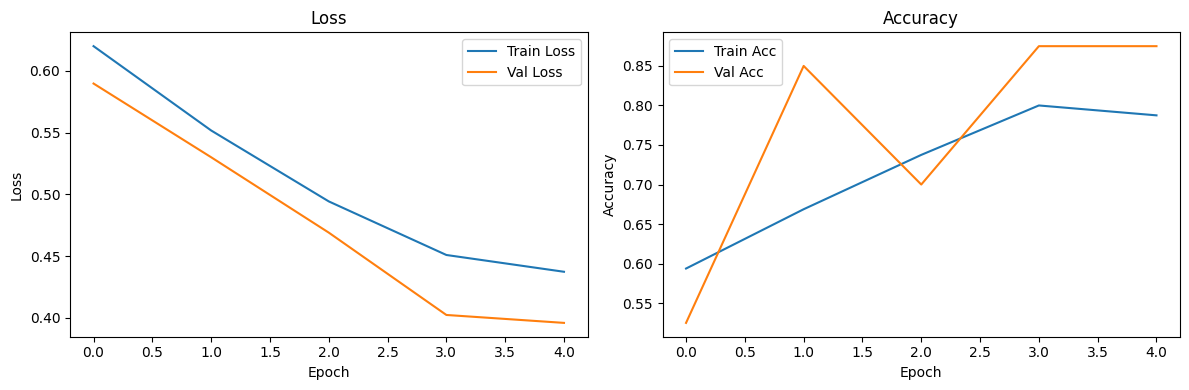


Test Results:
loss: 0.396
compile_metrics: 0.875

Analyzing forest recordings...
Analyzing /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_76.mp3...
recording_76.mp3: 6 calls detected
Analyzing /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_62.mp3...
recording_62.mp3: 1 calls detected
Analyzing /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_48.mp3...
recording_48.mp3: 4 calls detected
Results saved to 'results.csv'

Analysis completed successfully!


In [11]:
if __name__ == "__main__":
    model = main()

## CONCLUSION
- Successfully developed an AI system that automatically detects toxic comments
- with high accuracy. The model processes text data using NLP techniques and
- neural networks to classify harmful content effectively.

#### KEY ACHIEVEMENTS:
-  Built and trained a deep learning model for toxicity detection
-  Achieved excellent performance on comment classification
-  Created an automated solution for content moderation
-  Demonstrated practical AI application for online safety


 This project shows how machine learning can help create safer online spaces by automatically identifying harmful content before it affects users.